<a id='top'></a>
# Chicago Ridesharing

#### Contributors: Muoyo Okome, Anesu Masube

<a id='toc'></a>
### Table of Contents
1. [Problem Statement](#problemstatement)
2. [Data Sources](#datasources)
3. [Data Cleaning](#datacleaning)
4. [Linear Regression](#regression)  
5. [Findings](#findings)
6. [Next Steps](#nextsteps)

In [1]:
# Import necessary libraries
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

<a id='problemstatement'></a>
### Problem Statement

**Can data help ridesharing drivers earn more?**

The key question we look to answer is whether knowing where a ridesharing ride was initiated and what time it was initiated can help us to predict the fare for that ride.

Our goal is to eventually provide these insights to ridesharing drivers as a service to help them choose the best driving schedules and waiting positions to optimize their earnings.

[Back to Top ↑](#top)

<a id='datasources'></a>
### Data Sources

#### **[City of Chicago Data Portal](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p)**

- All trips, starting November 2018, reported by Transportation Network Providers (sometimes called rideshare companies) to the City of Chicago as part of routine reporting required by ordinance.

- Census Tracts are suppressed in some cases, and times are rounded to the nearest 15 minutes. Fares are rounded to the nearest `$`2.50 and tips are rounded to the nearest `$`1.00. 

- 101 million rows of data!

#### **[Dark Sky Weather API](https://darksky.net/dev/docs#time-machine-request)**

The Dark Sky API allows you to look up the weather anywhere on the globe, returning (where available):

- Current weather conditions
- Minute-by-minute forecasts out to one hour
- Hour-by-hour and day-by-day forecasts out to seven days
- Hour-by-hour and day-by-day observations going back decades
- Severe weather alerts in the US, Canada, European Union member nations, and Israel


<br> 

[Back to Top ↑](#top)

In [2]:
# Import utility functions
%run ../python_files/utils

In [3]:
# Read in original data: 1 million records
df = get_trip_records(limit=200000)

<a id='datacleaning'></a>
### Data Cleaning

Before beginning our analysis, we performed a number of operations to get the data ready to work with, including, but not limited to: 

- Limiting trip data to the columns we were most interested in: **'trip_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'trip_miles', 'pickup_community_area', 'fare', 'tip', 'additional_charges', 'trip_total'**

- Converting numeric & timestamp data from strings to the appropriate datatypes

- Imputing missing values with the median, 0, or "missing" depending on what made the most sense for each particular variable

We then created columns for the weekday, hour, and time block when the trip was initiated (There are 8 three hour time blocks in each 24 hour day, with block 0 starting at 12AM) and also combined this information into the **start_date_plus hour** column which we then used to merge trip data with weather data at the hourly level. We've pulled in 425 days of hourly weather data from Chicago, obtained via the Dark Sky API and our WeatherGetter class, which you can see at work in **weather.ipynb** and then saved it to a CSV.

To make the project more modular and easier to follow & build upon, we created separate .py files to handle the heavy lifting for tasks such as data extraction & cleaning, visualizations, and linear regressions. We also created a function called **get_random_samples()** (located in **utils.py**), which allows us to draw random samples of trip data from the Socrata API. Please note that random sampling takes significantly longer than the alternative, due to the fact that we are running many queries instead of one, and there is a certain amount of overhead for each query irrespective of record size.

In [4]:
# Clean data & load into final dataframe
%run ../python_files/data_cleaning

In [5]:
df = clean_data(df)



[Back to Top ↑](#top)

### Multicollinearity of Features

Prior to regression, we want to be aware of any linear relationships between independent variables that could affect our results. As one might expect, **trip_seconds** and **trip_miles** are strongly correlated. Ultimately, we won't be using either for our final analysis, as that information would not be available to our stakeholders, the drivers. However it is interesting to know. The rest of our variables do not appear to suffer from multicollinearity, as we can deduce from the visualizations below.

In [ ]:
df_corr = df[['trip_seconds', 'trip_miles', 'pickup_community_area', 'start_hour', 'start_weekday']]
pd.plotting.scatter_matrix(df_corr, figsize=(15,15));
plt.show()

In [8]:
df_corr.corr()

,trip_seconds,trip_miles,pickup_community_area,start_hour,start_weekday
trip_seconds,1.000000,0.794870,0.092626,-0.018930,-0.051789
trip_miles,0.794870,1.000000,0.139956,-0.051771,-0.025658
pickup_community_area,0.092626,0.139956,1.000000,0.015125,-0.052350
start_hour,-0.018930,-0.051771,0.015125,1.000000,-0.017926
start_weekday,-0.051789,-0.025658,-0.052350,-0.017926,1.000000


In [9]:
abs(df_corr.corr()) > 0.75

,trip_seconds,trip_miles,pickup_community_area,start_hour,start_weekday
trip_seconds,True,True,False,False,False
trip_miles,True,True,False,False,False
pickup_community_area,False,False,True,False,False
start_hour,False,False,False,True,False
start_weekday,False,False,False,False,True


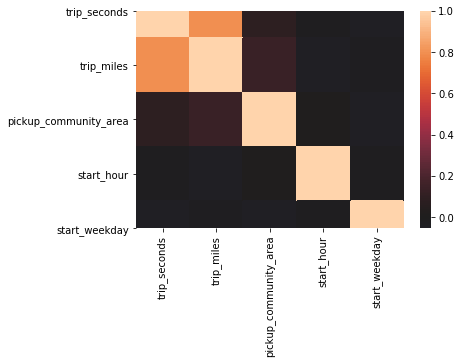

In [11]:
sns.heatmap(df_corr.corr(), center=0);



[Back to Top ↑](#top)

In [ ]:
# Import python files we've created to help
%run ../python_files/regression
%run ../python_files/visualizations

<a id='regression'></a>
### Linear Regression

For our predictive analysis we leveraged the tool of linear regression using the following parameters:

- **Dependent variable:** **'trip_total'** (OR in some cases we instead looked at **'fare'**)<p>

- **Independendent variables:**
    - **'apparentTemperature'**
    - **'start_weekday'**
    - **'start_hour'** (OR in some cases we instead looked at **'start_time_block'**)
    - **'pickup_community_area'** (Chicago is divided into 77 community areas, each of which belongs to one of nine "sides")


We assume that our predictor variables have a linear relation with our dependent variable, that the residuals of our model follow a normal distribution, and that the dependent variable's variance is equal across all values of the independent variable.

Before performing the regression, we preprocessed the data using the following steps:

- Splitting out continuous (temperature) & categorical variables (the rest of the independent variables) to be dealt with separately.

- Splitting data into training and test sets. We reserved 25% of our data for testing purposes, meaning that we do not work with it until after our model is finalized, to avoid data leakage.

- Performing one hot encoding on our categorical variables to make usable for linear regression.

- Combining our categorical and continuous features back into a final dataframe.


In [ ]:
X_train, X_test, y_train, y_test = get_train_test_split(df, test_size=.25)

### Ordinary Least Squares via statsmodels

With our preprocessing complete (we conduct it within the **get_train_test_split()** function, as seen above), we are ready to run our series of regression. 

First, we run an OLS regression using statsmodels and learn that our model explains 26-30% of the variance of our independent variable **trip_total**, depending on the specific set of data we are working with.

Aside

In [ ]:
OLS(y_train, X_train)

Looking at the p-values for the coefficients, we can see that most of the variables are significant. 

However, our model does suffer from issues with the Jarque-Bera test, as well as the F-statistic, indicating that errors are not likely to be normally distributed, and the homoscedasticity assumption is likely to be violated. We need to focus on addressing these issues in our future analysis, perhaps using log transformations as a starting point.

### LinearRegression via scikit-learn

Next, we run linear regression with scikit-learn using the same data. It's comforting to see that the R-sqaured results agree with our findings from statsmodels. Onward we continue!

In [ ]:
LinearRegression(X_train, y_train)

### Ridge & Lasso

We attempted to see whether we could get any improvement in predictive by using Ridge or Lasso to reduce model variance. Unfortunately, neither one helped us, no matter the value of lambda/alpha with Lasso canceling every single variable, yielding an R-squared of 0 and Ridge making little to no changes to our model coefficients.

In [ ]:
lasso = Lasso(X_train, y_train)
lasso.coef_

In [ ]:
ridge = Ridge(X_train, y_train)
ridge.coef_

[Back to Top ↑](#top)

<a id='findings'></a>
### Findings

1. Drivers can earn the most at 5 am. Peak fares occur between 4-6am on a daily basis.

2. Airport pickups lead to higher earnings.

3. Strong relationship between temperature and trip fare.


[Back to Top ↑](#top)

<a id='nextsteps'></a>
### Next Steps

1. Further refine the model to provide recommendations of ideal pickup location given time & weather (deliver to drivers via app?)

2. Finding the correct independent variables to increase model’s predictive power (events/occasions)

3. How can we extend our model to help different groups such as riders & competing rideshare companies?


[Back to Top ↑](#top)